# Calibrating the velocity field against observations 

In [8]:
# Copyright (C) 2024 Richard Stiskalek
# This program is free software; you can redistribute it and/or modify it
# under the terms of the GNU General Public License as published by the
# Free Software Foundation; either version 3 of the License, or (at your
# option) any later version.
#
# This program is distributed in the hope that it will be useful, but
# WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General
# Public License for more details.
#
# You should have received a copy of the GNU General Public License along
# with this program; if not, write to the Free Software Foundation, Inc.,
# 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
import numpy as np
import matplotlib.pyplot as plt
import jax
from numpyro.infer import MCMC, NUTS, init_to_median
import corner
from getdist import plots
from scipy.stats import multivariate_normal

import csiborgtools

from flow_calibration import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## LOS density & radial velocity plots 

In [ ]:
# fpath = "/mnt/extraspace/rstiskalek/catalogs/A2.h5"
fpath = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation_Supranta2019.hdf5"

loader_carrick = csiborgtools.flow.DataLoader("Carrick2015", "LOSS", fpath, paths, ksmooth=0)
loader_csiborg = csiborgtools.flow.DataLoader("csiborg1", "LOSS", fpath, paths, ksmooth=0)
loader_csiborg2 = csiborgtools.flow.DataLoader("csiborg2_main", "LOSS", fpath, paths, ksmooth=0)

In [ ]:
# ks = [115,  53,  77, 105,  26,  61,  86,  29,  80,  21]
ks = [19,  8, 15,  0, 16,  6, 48, 38, 26, 44]
# ks = [19]
# ks = np.random.choice(50, 10, replace=False)

# k = 6
for k in []:
    fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
    # Get rid of vertical spacing
    fig.subplots_adjust(wspace=0)

    # Plot CSiBORG
    for i in range(loader_csiborg.los_density.shape[1]):
        axs[0].plot(loader_csiborg.rdist, loader_csiborg.los_density[k, i, :], alpha=0.1, color="black")
        axs[1].plot(loader_csiborg.rdist, loader_csiborg.los_radial_velocity[k, i, :], alpha=0.1, color="black")

    # CSiBORG1
    axs[0].plot(loader_csiborg.rdist, loader_csiborg.los_density[k, :, :].mean(axis=0), color="red", label="CSiBORG1")
    axs[1].plot(loader_csiborg.rdist, loader_csiborg.los_radial_velocity[k, :, :].mean(axis=0), color="red")

    # CSiBORG2
    axs[0].plot(loader_csiborg2.rdist, loader_csiborg2.los_density[k, :, :].mean(axis=0), color="violet", label="CSiBORG2")
    axs[1].plot(loader_csiborg2.rdist, loader_csiborg2.los_radial_velocity[k, :, :].mean(axis=0), color="violet")

    # Plot Carrick+2015
    axs[0].plot(loader_carrick.rdist, loader_carrick.los_density[k, 0, :], color="blue", label="Carrick+2015")
    axs[1].plot(loader_carrick.rdist, loader_carrick.los_radial_velocity[k, 0, :] * 0.43, color="blue")


    # for i in range(2):
    #     label = "SN"
    #     rdist = loader_csiborg.cat["r_hMpc"][k]
    #     axs[i].axvline(rdist, color="violet", linestyle="--",
    #                 zorder=0, label=label)

    axs[1].set_xlabel(r"$r ~ [\mathrm{Mpc} / h]$")
    axs[0].set_ylabel(r"$\rho_{\rm LOS} / \langle \rho_{\rm matter} \rangle$")
    axs[1].set_ylabel(r"$v_{\rm LOS} ~ [\mathrm{km/s}]$")

    axs[0].set_yscale("log")

    axs[0].legend(loc="upper right")
    axs[0].set_xlim(0, 200)

    fig.tight_layout(w_pad=0, h_pad=0)
    fig.savefig(f"../plots/LOSS_los_{k}.png", dpi=500, bbox_inches="tight")

    fig.show()

## Test running a model

In [715]:
fpath_data = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation_Supranta2019.hdf5"
# fpath_data = "/mnt/extraspace/rstiskalek/catalogs/A2.h5"

simname = "Carrick2015"
catalogue = "2MTF"
loader = csiborgtools.flow.DataLoader(simname, 0, catalogue, fpath_data, paths, ksmooth=0)
get_model_kwargs = {"zcmb_max": 0.07}

16:37:06: reading the catalogue.
16:37:06: reading the interpolated field.
16:37:07: calculating the radial velocity.


/mnt/users/rstiskalek/csiborgtools/csiborgtools/flow/flow_model.py:112: UserWarning: The number of radial steps is even. Skipping the first step at 0.0 because Simpson's rule requires an odd number of steps.
  warn(f"The number of radial steps is even. Skipping the first "


#### Running HMC

In [716]:
model = csiborgtools.flow.get_model(loader, **get_model_kwargs)

Selected 1248/1248 galaxies.


In [717]:
kernel = NUTS(model, init_strategy=init_to_median(num_samples=100))
mcmc = MCMC(kernel, num_warmup=250, num_samples=500)

rng_key = jax.random.PRNGKey(5)

In [718]:
model_kwargs = {"sample_alpha": True}
mcmc.run(rng_key, **model_kwargs)

sample: 100%|██████████| 750/750 [02:44<00:00,  4.57it/s, 7 steps of size 4.96e-01. acc. prob=0.91]  


In [719]:
mcmc.print_summary()
samples = mcmc.get_samples(group_by_chain=False)
# print(csiborgtools.numpyro_gof(model, mcmc, len(loader.cat), model_kwargs))


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
          Vext_x   -106.65     16.42   -107.21   -131.51    -76.54    730.09      1.00
          Vext_y   -103.97     18.51   -103.36   -135.46    -74.95    564.72      1.00
          Vext_z   -114.45     18.16   -115.19   -145.14    -86.94    398.98      1.00
               a    -22.28      0.02    -22.28    -22.31    -22.25    451.84      1.00
           alpha      1.53      0.08      1.53      1.40      1.64    625.30      1.00
               b     -6.28      0.09     -6.28     -6.42     -6.12    685.29      1.00
            beta      0.40      0.03      0.40      0.37      0.45    607.03      1.00
  e_mu_intrinsic      0.41      0.01      0.41      0.39      0.42    469.01      1.00
         sigma_v    116.06     11.30    115.85     99.31    134.60    715.52      1.00

Number of divergences: 0


In [720]:
zobs_mean, zobs_std = model.predict_zobs(samples)

zobs_mean *= SPEED_OF_LIGHT
zobs_std *= SPEED_OF_LIGHT

truths = model._z_obs * SPEED_OF_LIGHT

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:06<00:00, 78.97it/s]


In [729]:
mu, sigma = model.summarize_zobs_pred(zobs_mean, zobs_std)

true = model._z_obs * SPEED_OF_LIGHT

nu = model.ndata - len(samples.keys())

In [730]:
z = (true - mu) / sigma

In [731]:
z.mean(), z.std()

(Array(-0.00459124, dtype=float32), Array(1.1113781, dtype=float32))

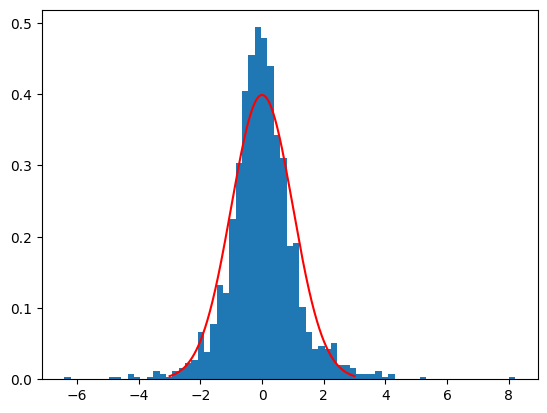

In [732]:
from scipy.stats import norm

plt.figure()
plt.hist(z, bins="auto", density=1)
xrange = np.linspace(-3, 3, 1000)
plt.plot(xrange, norm.pdf(xrange), color="red")
plt.show()

In [733]:

chi2 = [np.sum((zobs_mean[:, i] - true)**2 / zobs_std[:, i]**2) / nu for i in range(500)]

In [734]:
np.mean(chi2), np.std(chi2)

(1.2584376, 0.06970586)

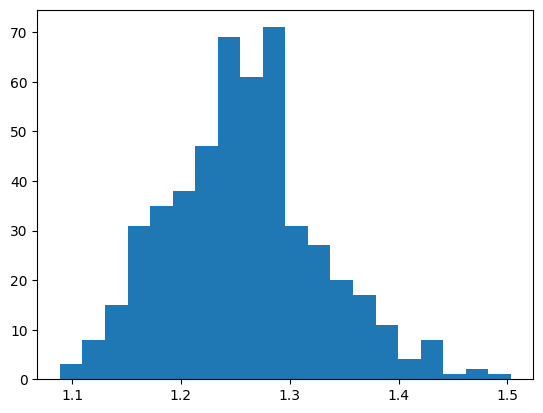

In [735]:
plt.figure()
plt.hist(chi2, bins="auto")
# plt.xlim(0, 10)
plt.show()

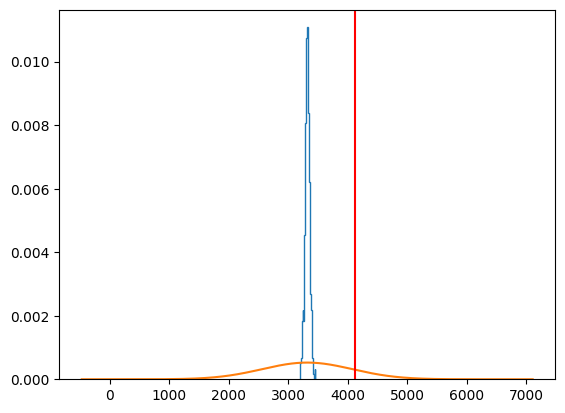

In [736]:
k = 40
plt.figure()

plt.hist(zobs_mean[k], bins="auto", histtype="step", density=1)

mu, std = average_normal(zobs_mean[k], zobs_std[k])
xrange = np.linspace(mu - 5 * std, mu + 5 * std, 1000)
plt.plot(xrange, norm(mu, std).pdf(xrange))


plt.axvline(model._z_obs[k] * SPEED_OF_LIGHT, c="red")


plt.show()

In [375]:
%timeit model.predict_zobs_single(**x)

13.6 ms ± 2.81 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [377]:
from jax import jit
f = jit(model.predict_zobs_single)

In [379]:
%timeit f(**x)

351 µs ± 44.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [314]:
f(samples)

{'Vext_x': Array([-5.83605766e+01, -4.48799133e+00, -3.05757217e+01, -7.66664743e+00,
        -2.69268456e+01, -1.16219368e+02, -3.09365997e+01, -5.74244843e+01,
        -1.17672356e+02, -1.69579987e+02,  1.19277534e+02, -2.26422394e+02,
        -6.61962891e+01,  9.16308212e+00,  5.24288406e+01, -9.98250275e+01,
        -9.88435440e+01,  1.15745605e+02,  7.89659653e+01,  1.10501051e+00,
        -2.22662983e+01,  1.60512924e+01, -7.25026398e+01,  3.52423172e+01,
         1.77226658e+01,  3.65560074e+01,  6.44533615e+01, -8.06784630e+00,
        -6.15262985e+00,  3.26341391e+00,  1.62363770e+02, -1.77923859e+02,
        -7.69411621e+01, -1.32364330e+01, -5.67368584e+01, -9.00284348e+01,
        -3.54667587e+01, -4.51107025e+01, -4.51034889e+01, -6.99444427e+01,
         5.81185837e+01,  3.35252304e+01, -5.58608475e+01, -1.48146454e+02,
         3.39922905e+01,  1.14302574e+02, -9.00884552e+01,  9.28695221e+01,
         9.01381378e+01, -1.19254616e+02, -4.82597961e+01, -6.64224014e+01,
  

In [298]:
test_samples = {key: samples[key] for key in samples.keys()}
SPEED_OF_LIGHT = 299792.458

In [299]:
zobs_pred = model.predict_zobs(test_samples)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:04<00:00, 249.79it/s]


In [300]:
zobs_pred[..., 0].shape

(125, 1000)

In [301]:
x = [np.sum(((zobs_pred[:, i, 0] - model._z_obs) * SPEED_OF_LIGHT)**2 / (zobs_pred[:, i, 1] * SPEED_OF_LIGHT)**2) / (model.ndata - len(test_samples.keys())) for i in range(model.ndata)]

In [303]:
np.mean(x), np.std(x)

(16.852997, 11.355076)

In [304]:
def combine_normal(mus, sigmas):
    mu = np.mean(mus, axis=-1)
    var = np.mean(sigmas**2 + mus**2, axis=-1) - mu**2

    return mu, var**0.

In [250]:
mu, std = combine_normal(zobs_pred[..., 0], zobs_pred[..., 1])
mu *= SPEED_OF_LIGHT
std *= SPEED_OF_LIGHT

In [251]:
np.sum((model._z_obs * SPEED_OF_LIGHT - mu)**2 / (std**2)) / (model.ndata - len(test_samples.keys()))

Array(0.6578178, dtype=float32)

341.5015


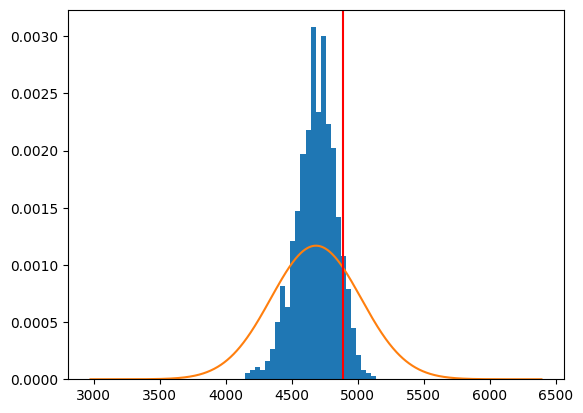

In [253]:
from scipy.stats import norm
k = 30

print(std[k])

xrange = np.linspace(mu[k] - 5 * std[k], mu[k] + 5 * std[k], 1000)

plt.figure()
plt.hist(zobs_pred[..., 0][k] * SPEED_OF_LIGHT, bins="auto", density=0.1)
plt.plot(xrange, norm(mu[k], std[k]).pdf(xrange))

plt.axvline(model._z_obs[k] * SPEED_OF_LIGHT, c="red")


plt.show()


In [226]:
(zobs_pred[..., 1]**2).shape

(125, 1000)

In [227]:
Vmag = np.sqrt(samples["Vext_x"]**2 + samples["Vext_y"]**2 + samples["Vext_z"]**2)

V = np.vstack([samples["Vext_x"], samples["Vext_y"], samples["Vext_z"]]).T
V = csiborgtools.cartesian_to_radec(V)

l, b = csiborgtools.flow.radec_to_galactic(V[:, 1], V[:, 2])

print(f"|V|  = {np.mean(Vmag)} +- {np.std(Vmag)}")
print(f"l    = {np.mean(l)} +- {np.std(l)}")
print(f"b    = {np.mean(b)} +- {np.std(b)}")
print(f"beta = {np.mean(samples['beta'])} +- {np.std(samples['beta'])}")

|V|  = 292.9063720703125 +- 53.499855041503906
l    = 254.50001033175045 +- 14.125642497928322
b    = 19.794461051654427 +- 10.697396482974687
beta = 0.31970617175102234 +- 0.07021637260913849


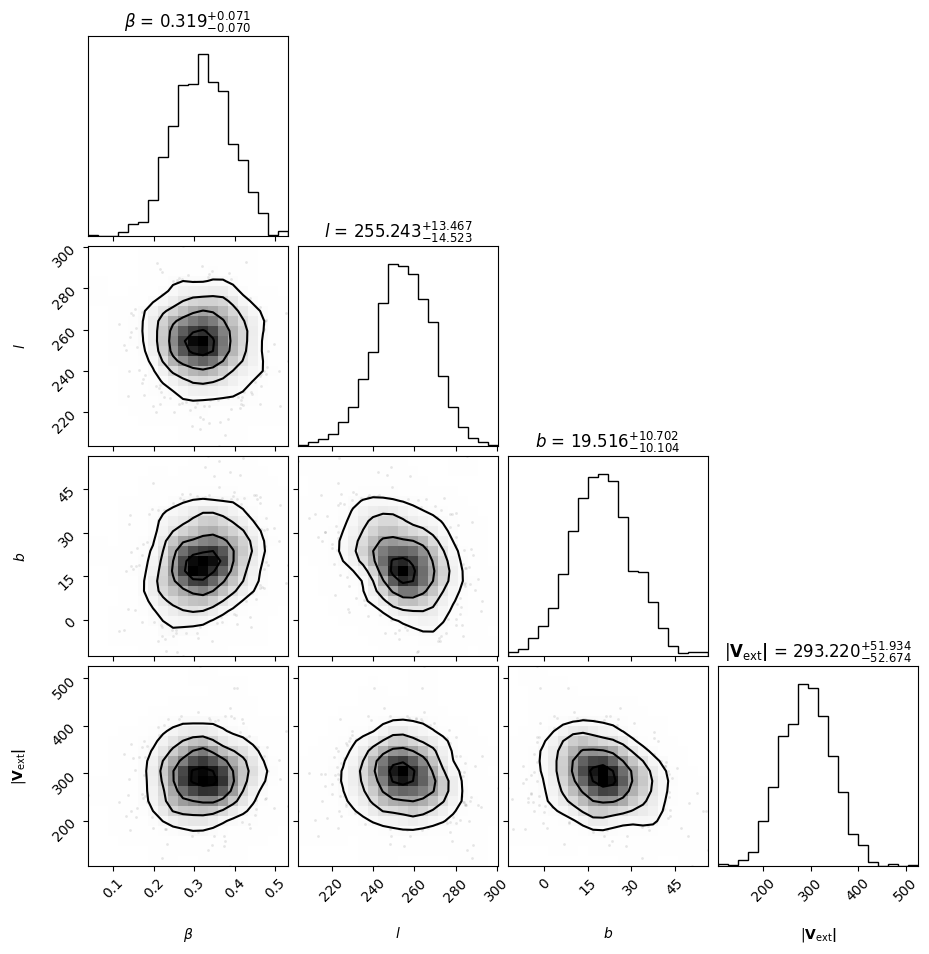

In [228]:
if "alpha" in samples:
    data = np.vstack([samples["alpha"], samples["beta"], l, b, Vmag]).T
    labels = [r"$\alpha$", r"$\beta$", r"$l$", r"$b$", r"$|\bf{V}_{\rm ext}|$"]
else:
    data = np.vstack([samples["beta"], l, b, Vmag]).T
    labels = [r"$\beta$", r"$l$", r"$b$", r"$|\bf{V}_{\rm ext}|$"]

fig = corner.corner(data, labels=labels, show_titles=True, title_fmt=".3f", title_kwargs={"fontsize": 12}, smooth=1)

## Vizualize the results

####  Functions to read in the results

In [ ]:
data, names, gof = read_samples("2MTF", "Carrick2015", 0)

fig = corner.corner(data, labels=names_to_latex(names, True), show_titles=True,
                    title_fmt=".3f", title_kwargs={"fontsize": 12}, smooth=1)

### LOSS-only comparison

In [ ]:
LOSS_Carrick_0 = read_samples("LOSS", "Carrick2015", 0, return_MCsamples=True)
LOSS_Carrick_1 = read_samples("LOSS", "Carrick2015", 1, return_MCsamples=True)

LOSS_CB1_0 = read_samples("LOSS", "csiborg1", 0, return_MCsamples=True)
LOSS_CB1_1 = read_samples("LOSS", "csiborg1", 1, return_MCsamples=True)

LOSS_CB2_0 = read_samples("LOSS", "csiborg2_main", 0, return_MCsamples=True)
LOSS_CB2_1 = read_samples("LOSS", "csiborg2_main", 1, return_MCsamples=True)

In [ ]:
X = [
     LOSS_Carrick_0,
     # LOSS_Carrick_1,
     # LOSS_CB1_0,
     LOSS_CB1_1,
     LOSS_CB2_0,
     LOSS_CB2_1,
     ]

# params = ["l", "b", "Vmag", "beta"]
params = None

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right', )
g.export(f"../plots/LOSS_comparison.png", dpi=500,)


### Foundation-only comparison

In [ ]:
FOUNDATION_Carrick_0 = read_samples("Foundation", "Carrick2015", 0, return_MCsamples=True)
FOUNDATION_Carrick_1 = read_samples("Foundation", "Carrick2015", 1, return_MCsamples=True)

FOUNDATION_CB1_0 = read_samples("Foundation", "csiborg1", 0, return_MCsamples=True)
FOUNDATION_CB1_1 = read_samples("Foundation", "csiborg1", 1, return_MCsamples=True)

FOUNDATION_CB2_0 = read_samples("Foundation", "csiborg2_main", 0, return_MCsamples=True)
FOUNDATION_CB2_1 = read_samples("Foundation", "csiborg2_main", 1, return_MCsamples=True)

In [ ]:
X = [
    FOUNDATION_Carrick_0,
    # FOUNDATION_Carrick_1,
    # FOUNDATION_CB1_0,
    FOUNDATION_CB1_1,
    FOUNDATION_CB2_0,
    FOUNDATION_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/FOUNDATION_comparison.png", dpi=500,)

### PantheonPlus-only comparison

In [ ]:
PANTHEONP_Carrick_0 = read_samples("Pantheon+", "Carrick2015", 0, return_MCsamples=True)
PANTHEONP_Carrick_1 = read_samples("Pantheon+", "Carrick2015", 1, return_MCsamples=True)

PANTHEONP_CB1_0 = read_samples("Pantheon+", "csiborg1", 0, return_MCsamples=True)
PANTHEONP_CB1_1 = read_samples("Pantheon+", "csiborg1", 1, return_MCsamples=True)

# STILL RUNNING
# PANTHEONP_CB2_0 = read_samples("Pantheon+", "csiborg2_main", 0, return_MCsamples=True)
PANTHEONP_CB2_1 = read_samples("Pantheon+", "csiborg2_main", 1, return_MCsamples=True)


In [ ]:
X = [
    PANTHEONP_Carrick_0,
    # PANTHEONP_Carrick_1,
    # PANTHEONP_CB1_0,
    PANTHEONP_CB1_1,
    # PANTHEONP_CB2_0,
    PANTHEONP_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/PANTHEONP_comparison.png", dpi=500,)

### 2MTF comparison

In [ ]:
TWOMTF_Carrick_0 = read_samples("2MTF", "Carrick2015", 0, return_MCsamples=True)
TWOMTF_Carrick_1 = read_samples("2MTF", "Carrick2015", 1, return_MCsamples=True)

TWOMTF_CB1_0 = read_samples("2MTF", "csiborg1", 0, return_MCsamples=True)
TWOMTF_CB1_1 = read_samples("2MTF", "csiborg1", 1, return_MCsamples=True)

TWOMTF_CB2_0 = read_samples("2MTF", "csiborg2_main", 0, return_MCsamples=True)
TWOMTF_CB2_1 = read_samples("2MTF", "csiborg2_main", 1, return_MCsamples=True)


In [ ]:
X = [
    TWOMTF_Carrick_0,
    # TWOMTF_Carrick_1,
    # TWOMTF_CB1_0,
    TWOMTF_CB1_1,
    TWOMTF_CB2_0,
    TWOMTF_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/2MTF_comparison.png", dpi=500,)

### SFI galaxies

In [ ]:
SFIGAL_Carrick_0 = read_samples("SFI_gals", "Carrick2015", 0, return_MCsamples=True)
SFIGAL_Carrick_1 = read_samples("SFI_gals", "Carrick2015", 1, return_MCsamples=True)

# SFIGAL_CB1_0 = read_samples("SFI_gals", "csiborg1", 0, return_MCsamples=True)
# SFIGAL_CB1_1 = read_samples("SFI_gals", "csiborg1", 1, return_MCsamples=True)

SFIGAL_CB2_0 = read_samples("SFI_gals", "csiborg2_main", 0, return_MCsamples=True)
SFIGAL_CB2_1 = read_samples("SFI_gals", "csiborg2_main", 1, return_MCsamples=True)

In [ ]:
X = [
    SFIGAL_Carrick_0,
    # SFIGAL_Carrick_1,
    # SFIGAL_CB1_0,
    # SFIGAL_CB1_1,
    # SFIGAL_CB2_0,
    SFIGAL_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/SFI_gals_comparison.png", dpi=500,)

### External flow consistency

#### Carrick2015

In [ ]:
X = [
    # LOSS_Carrick_0,
    # FOUNDATION_Carrick_0,
    PANTHEONP_Carrick_0,
    TWOMTF_Carrick_0,
    SFIGAL_Carrick_0,
    ]

params = ["Vmag", "l", "b", "beta"]
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right',)
g.export(f"../plots/Carrick2015_external_flow.png", dpi=500,)

#### CSiBORG1

In [ ]:
X = [
    # LOSS_CB1_1,
    # FOUNDATION_CB1_1,
    PANTHEONP_CB1_1,
    TWOMTF_CB1_1,
    # SFIGAL_CB1_1,
    ]

params = ["Vmag", "l", "b", "beta"]
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right',)
g.export(f"../plots/CB1_external_flow.png", dpi=500,)

#### CSiBORG2

In [ ]:
X = [
    # LOSS_CB2_1,
    # FOUNDATION_CB2_1,
    PANTHEONP_CB2_1,
    TWOMTF_CB2_1,
    SFIGAL_CB2_1,
    ]

params = ["Vmag", "l", "b", "beta"]
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right',)
g.export(f"../plots/CB2_external_flow.png", dpi=500,)

In [3]:
k = 0
LG = 0
# CSiBORG2
LOSS_CB2_LG = read_samples("LOSS", "csiborg2_main", k, return_MCsamples=True,subtract_LG_velocity=LG)
FOUNDATION_CB2_LG = read_samples("Foundation", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)
# PANTHEON_CB2_LG = read_samples("Pantheon+", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=0)
TWOMTF_CB2_LG = read_samples("2MTF", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)
SFIGAL_CB2_LG = read_samples("SFI_gals", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)

# CSiBORG1
LOSS_CB1_LG = read_samples("LOSS", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)
FOUNDATION_CB1_LG = read_samples("Foundation", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)
PANTHEON_CB1_LG = read_samples("Pantheon+", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)
TWOMTF_CB1_LG = read_samples("2MTF", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)
SFIGAL_CB1_LG = read_samples("SFI_gals", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)


Reading LOSS fitted to csiborg2_main with ksmooth = 0.


Reading off enclosed velocity from R = 3.383 Mpc / h.
BIC  = 758.646942 +- 7.900863
AIC  = 739.526703 +- 7.900863
logZ = -350.513582 +- 2.973401
Removed no burn in

Reading Foundation fitted to csiborg2_main with ksmooth = 0.
Reading off enclosed velocity from R = 3.383 Mpc / h.
BIC  = 1862.151703 +- 5.628656
AIC  = 1833.948944 +- 5.628656
logZ = -902.754858 +- 2.689162
Removed no burn in

Reading 2MTF fitted to csiborg2_main with ksmooth = 0.
Reading off enclosed velocity from R = 3.383 Mpc / h.
BIC  = 19248.799609 +- 38.583873
AIC  = 19202.635547 +- 38.583873
logZ = -9598.394336 +- 19.251815
Removed no burn in

Reading SFI_gals fitted to csiborg2_main with ksmooth = 0.
Reading off enclosed velocity from R = 3.383 Mpc / h.
BIC  = 28779.863770 +- 42.922014
AIC  = 28730.453613 +- 42.922014
logZ = -14356.845068 +- 21.362802
Removed no burn in

Reading LOSS fitted to csiborg1 with ksmooth = 0.
Reading off enclosed velocity from R = 3.3885 Mpc / h.
BIC  = 775.752704 +- 5.665501
AIC  = 756.

Removed no burn in


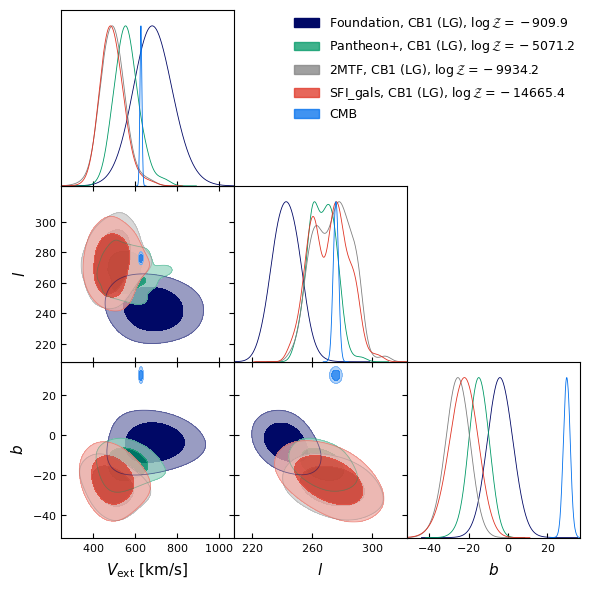

In [6]:
params = ["Vmag", "l", "b"]
CMB = MCSamples(samples=multivariate_normal([627, 276, 30], [22, 3, 3]).rvs(size=20000),
                names=params, labels=names_to_latex(params, True), label="CMB")

X = [
    # LOSS_CB1_LG,
    FOUNDATION_CB1_LG,
    PANTHEON_CB1_LG,
    TWOMTF_CB1_LG,
    SFIGAL_CB1_LG,
    # LOSS_CB2_0,
    # LOSS_CB2_LG,
    # FOUNDATION_CB2,
    # FOUNDATION_CB2_LG,
    # FOUNDATION_CB1_LG,
    # PANTHEON_CB2,
    # PANTHEON_CB2_LG,
    # TWOMTF_CB1,
    # TWOMTF_CB1_LG,
    # TWOMTF_CB2,
    # TWOMTF_CB2_LG,
    # SFIGAL_CB2,
    # SFIGAL_CB2_LG,
    CMB,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right')
g.export(f"../plots/CB1_dipole.png", dpi=500,)